# LIGHT CURVE SINE WAVES PERIOD FITTING

In [12]:
from AROMA.utils import *
from AROMA.config import *
import pandas as pd
%matplotlib widget
data = pd.read_csv(data_path, header=0, delimiter='\t')
data['EFLUX'] = 0.00474
time=data.TIME*24
lc  =data.PSF_FLUX_NORM
elc =data.EFLUX
fit_dir = '/Users/fuda/Documents/GitHub/aroma/AROMA_An_Exo_Rot_Mapping/notebooks/periodSineFit_metadata/'

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
print('def: find_nearest(array, value)')

def powerfunc_six(hpp,amp1,shift1,amp2,shift2,amp3,shift3,amp4,shift4,amp5,shift5,amp6,shift6):
    shifted1=amp1*shift(sinepw,shift1)
    shifted2=amp2*shift(sinepw,shift2)
    shifted3=amp3*shift(sinepw,shift3)
    shifted4=amp4*shift(sinepw,shift4)
    shifted5=amp5*shift(sinepw,shift5)
    shifted6=amp6*shift(sinepw,shift6)
    return shifted1+shifted2+shifted3+shifted4+shifted5+shifted6
print('def: powerfunc_six(hpp,amp1,shift1,amp2,shift2,amp3,shift3,amp4,shift4,amp5,shift5,amp6,shift6)')

def powerfunc_four(hpp,amp1,shift1,amp2,shift2,amp3,shift3,amp4,shift4):
    shifted1=amp1*shift(sinepw,shift1)
    shifted2=amp2*shift(sinepw,shift2)
    shifted3=amp3*shift(sinepw,shift3)
    shifted4=amp4*shift(sinepw,shift4)
    return shifted1+shifted2+shifted3+shifted4
print('def: powerfunc_four(hpp,amp1,shift1,amp2,shift2,amp3,shift3,amp4,shift4)')
      
def powerfunc(hpp,amp1,shift1,amp2,shift2,amp3,shift3):
    shifted1=amp1*shift(sinepw,shift1)
    shifted2=amp2*shift(sinepw,shift2)
    shifted3=amp3*shift(sinepw,shift3)
    return shifted1+shifted2+shifted3
print('def: powerfunc(hpp,amp1,shift1,amp2,shift2,amp3,shift3)')
      
def powerfuncsingle(hpp,amp1,shift1):
    shifted1=amp1*shift(sinepw,shift1)
    return shifted1
print('def: powerfuncsingle(hpp,amp1,shift1)')

def: find_nearest(array, value)
def: powerfunc_six(hpp,amp1,shift1,amp2,shift2,amp3,shift3,amp4,shift4,amp5,shift5,amp6,shift6)
def: powerfunc_four(hpp,amp1,shift1,amp2,shift2,amp3,shift3,amp4,shift4)
def: powerfunc(hpp,amp1,shift1,amp2,shift2,amp3,shift3)
def: powerfuncsingle(hpp,amp1,shift1)


### SINE WAVES FITTING
We now proceed to fitting multiple periods as compounded signal to compare with the data.
The periodogram is generated with the fourier transform(?)

In [13]:
# Replace data with test sine wave
mu, sigma = 1.0, 0.013 # mean and standard deviation
noise = random.normal(mu, sigma, len(time))
period1 = 5.28
period2 = 5.23
period3 = 5.28
period4 = 5.45

sinelc = 1.0+0.010*np.sin(2*np.pi*(time/period1))#+noise
#sinelc2 = 1.0+0.010*np.sin(2*np.pi*(time/period2))+noise+0.010*np.sin(2*np.pi*(time/period3))
#sinelc3 = 1.0+0.003*np.sin(2*np.pi*(time/period2))+noise+0.008*np.sin(2*np.pi*(time/period3))+0.004*np.sin(2*np.pi*(time/period4))

#elc=np.ones(10000)/1000.
#period = 15.
#lc = 0.5*np.sin(2*np.pi*(time/period))

#frequen = np.linspace(0.003,10.,100000)
periodmax=6.
periodmin=4.
frequen = np.linspace(1/periodmax,1/periodmin,1000)

# Compute the GLS periodogram with default options.
# Choose Zechmeister-Kuerster normalization explicitly
clp = pyPeriod.Gls((time,lc,elc), norm="ZK", freq=frequen,ofac=10)

# Calculate the Periodogram for the Window Function
#wlp = pyPeriod.Gls((wtime,window), norm="ZK", freq=frequen,ofac=10)
#clp.info

sinelp=pyPeriod.Gls((time,sinelc), norm="ZK", freq=frequen,ofac=10)
#sinelp2=pyPeriod.Gls((time,sinelc2), norm="ZK", freq=frequen,ofac=10)
#sinelp3=pyPeriod.Gls((time,sinelc3), norm="ZK", freq=frequen,ofac=10)

### PLOTS OF MULTIPLE N-SINE WAVES FIT

Plotting difference N-sine waves fit, with the option to refit the periods of power function.

**SHOULD REREAD CODE FOR UNDERSTANDING**

In [14]:
fr = clp.freq
pw = clp.power
hpp = 1./fr

refindex=find_nearest(hpp,5.28)
#Window function:
#wfr = wlp.freq
#wpw = wlp.power
#whpp = 1./wfr

sinefr = sinelp.freq
sinepw = sinelp.power
sinehpp=1./sinefr

# sinefr2 = sinelp2.freq
# sinepw2 = sinelp2.power
# sinehpp2=1./sinefr2
#
# sinefr3 = sinelp3.freq
# sinepw3 = sinelp3.power
# sinehpp3=1./sinefr3

redo_model=float(input('Re-fit models?'))
#==========================================
# Fit Solution with Single Sine Wave
if redo_model==1:
    fii=200
    ssr=np.zeros([fii])
    best_ssr=99999.
    for ii in range(fii):
        guess=[rand(1)*5.0,rand(1)*600-300.]
        try:
            params, cov = curve_fit(powerfuncsingle, hpp, pw, guess,method='lm')
        except RuntimeError:
            print('Did not converge')

        #print('Fitted parameters:',params)
        fittedmodel=powerfuncsingle(hpp,params[0],params[1])
        ssr[ii]=np.sum(np.power(pw - fittedmodel, 2))
        print(ii,"  SSR:",ssr[ii], " Best SSR:", best_ssr)
        if ssr[ii] < best_ssr:
            print('Bingo!')
            best_ssr=ssr[ii]
            best_solution=params

    params_singlesine=best_solution
    with open(fit_dir+'best-fit-single-sinewave-parameters.pkl', 'wb') as output:
        pickle.dump(params_singlesine, output, pickle.HIGHEST_PROTOCOL)
else:
    with open(fit_dir+'best-fit-single-sinewave-parameters.pkl', 'rb') as input:
        params_singlesine = pickle.load(input)

fittedmodel_single=powerfuncsingle(hpp,params_singlesine[0],params_singlesine[1])
print, "Best-fit single sine parameters:", params_singlesine


Re-fit models? 1


0   SSR: 0.021694373896013842  Best SSR: 99999.0
Bingo!
1   SSR: 0.02701023023438836  Best SSR: 0.021694373896013842
2   SSR: 0.02651207861740515  Best SSR: 0.021694373896013842
3   SSR: 0.026944887465290696  Best SSR: 0.021694373896013842
4   SSR: 0.0242204369724473  Best SSR: 0.021694373896013842
5   SSR: 0.027110932071988232  Best SSR: 0.021694373896013842
6   SSR: 0.022807053182739703  Best SSR: 0.021694373896013842
7   SSR: 0.027046147078336687  Best SSR: 0.021694373896013842
8   SSR: 0.022807053175191203  Best SSR: 0.021694373896013842
9   SSR: 0.026913445762306754  Best SSR: 0.021694373896013842
10   SSR: 0.020559097756327905  Best SSR: 0.021694373896013842
Bingo!
11   SSR: 0.027100373344372576  Best SSR: 0.020559097756327905
12   SSR: 0.026801503918188172  Best SSR: 0.020559097756327905
13   SSR: 0.02706668117129687  Best SSR: 0.020559097756327905
14   SSR: 0.027102395523256096  Best SSR: 0.020559097756327905
15   SSR: 0.02657922520834445  Best SSR: 0.020559097756327905
16   SS

(<function print>,
 'Best-fit single sine parameters:',
 array([0.03218317, 8.25078262]))

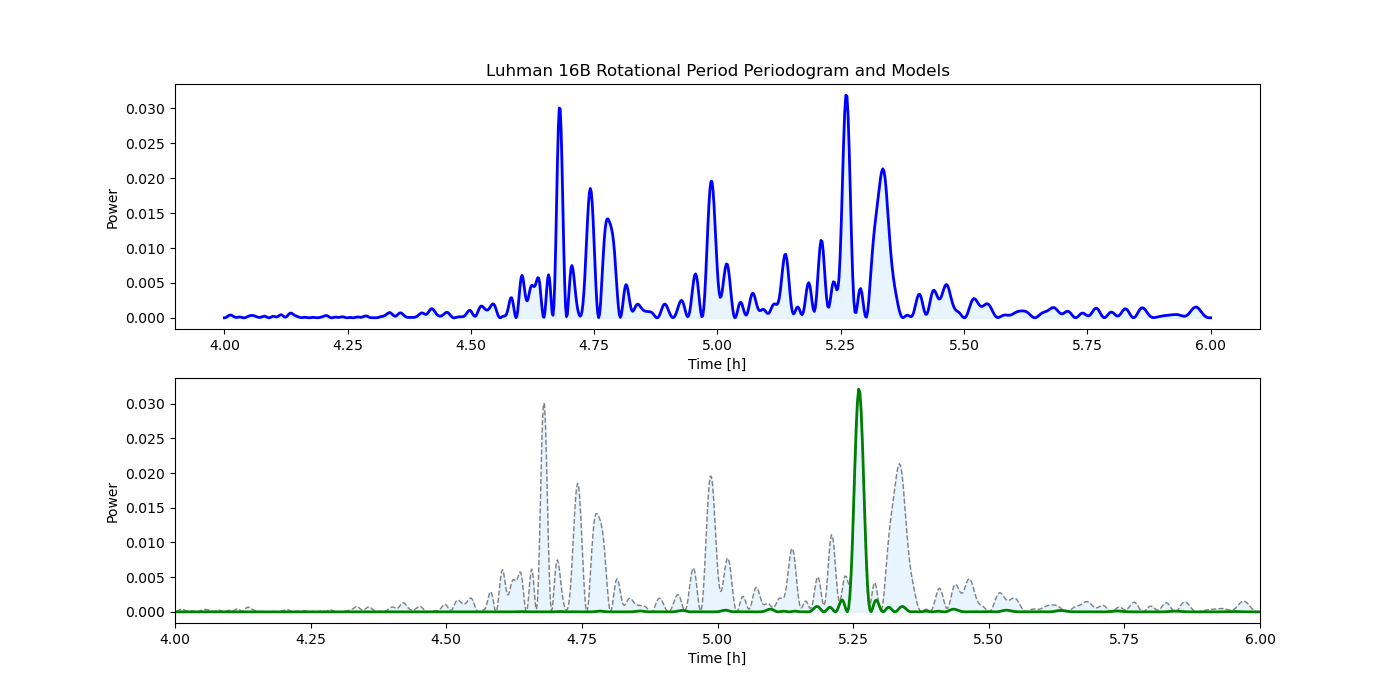

In [15]:
#==========================================
#PLOTTING
# xlim=[4.0,6.0]
# ylim=[0,0.025]
fig = plt.figure(figsize=(14,7))
matplotlib.rcParams.update({'font.size': 10})

plt.subplot(2,1,1)
plt.text(4.05,0.15,'Data: Luhman 16B Rotational Period Peak ',horizontalalignment='left',fontsize=15,color='blue')
plt.plot(hpp, pw, '-', linewidth=2,color='blue')
plt.fill_between(hpp, pw, interpolate=True, color='xkcd:light blue',alpha=0.2)
plt.xlabel('Time [h]')
plt.ylabel('Power')
plt.title('Luhman 16B Rotational Period Periodogram and Models')
# plt.xlim(xlim)
# plt.ylim(ylim)

plt.subplot(2,1,2)
#print('Shift for single sine wave fit:',int(round(refindex+params_singlesine[1])))
peak1=hpp[refindex+int(round(params_singlesine[1]))]
plt.text(4.05,0.15,'Model: Single sine wave',horizontalalignment='left',fontsize=15,color='green')
plt.text(4.05,0.10,'Period: {pk1:.2f} hr.'.format(pk1=peak1),horizontalalignment='left',fontsize=12,color='green')
plt.plot(hpp, pw, '--', linewidth=1,color='gray')
plt.fill_between(hpp, pw, interpolate=True, color='xkcd:light blue',alpha=0.2)
plt.plot(hpp,fittedmodel_single, '-', linewidth=2,color='green')
plt.xlabel('Time [h]')
plt.ylabel('Power')
plt.xlim(xlim)
periodmax=6.
periodmin=2.
frequen = np.linspace(1/periodmax,1/periodmin,1000)

# Compute the GLS periodogram with default options.
# Choose Zechmeister-Kuerster normalization explicitly
clp = pyPeriod.Gls((time,lc,elc), norm="ZK", freq=frequen,ofac=10)

# Calculate the Periodogram for the Window Function
#wlp = pyPeriod.Gls((wtime,window), norm="ZK", freq=frequen,ofac=10)
#clp.info

sinelp=pyPeriod.Gls((time,sinelc), norm="ZK", freq=frequen,ofac=10)

<bound method Gls.info of <PyAstronomy.pyTiming.pyPeriod.gls.Gls object at 0x7fae61545940>>


Text(0.5, 1.0, 'Luhman 16B Rotational Period Periodogram and Models')

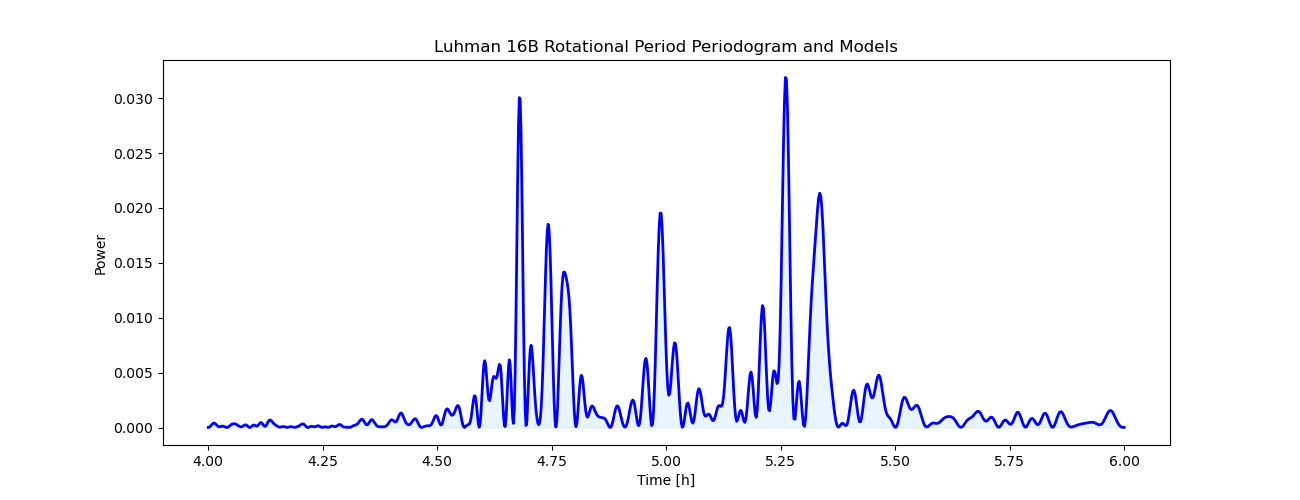

In [16]:
## TEST 2
periodmax=6.
periodmin=4.
frequen = np.linspace(1/periodmax,1/periodmin,1000)

# Compute the GLS periodogram with default options.
# Choose Zechmeister-Kuerster normalization explicitly

clp = pyPeriod.Gls((time,lc,elc), norm="ZK", freq=frequen,ofac=50)
print(clp.info)

fr = clp.freq
pw = clp.power
hpp = 1./fr

plt.figure(figsize=(13,5))
plt.text(4.05,0.15,'Data: Luhman 16B Rotational Period Peak ',horizontalalignment='left',fontsize=15,color='blue')
plt.plot(hpp, pw, '-', linewidth=2,color='blue')
plt.fill_between(hpp, pw, interpolate=True, color='xkcd:light blue',alpha=0.2)
plt.xlabel('Time [h]')
plt.ylabel('Power')
plt.title('Luhman 16B Rotational Period Periodogram and Models')